In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torch
import sys
sys.path.append('/home/suraj/Repositories/FM-extractors-radiomics/pyramid_pretraining')
from transforms.ssl import DictifyTransform, RandomResizedCrop
import numpy as np

from monai.visualize import blend_images


def plot_3d_image(ret):
    # Plot axial slice
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.imshow(ret[:, ret.shape[1] // 2, :, :].permute(1, 2, 0), cmap="gray")
    plt.title("Axial")
    plt.axis("off")

    # Plot sagittal slice
    plt.subplot(3, 1, 2)
    plt.imshow(ret[:, :, ret.shape[2] // 2, :].permute(1, 2, 0), cmap="gray")
    plt.title("Coronal")
    plt.axis("off")

    # Plot coronal slice
    plt.subplot(3, 1, 3)
    plt.imshow(ret[:, :, :, ret.shape[3] // 2].permute(1, 2, 0), cmap="gray")
    plt.title("Sagittal")

    plt.axis("off")
    plt.show()

In [2]:
data_dir = Path("/mnt/data1/datasets/ULS23")

In [3]:
images_dir = data_dir / "images"
annotations_dir = data_dir / "annotations"

In [4]:
datalist = []
for label_path in annotations_dir.rglob("*.nii.gz"):
    image_path = Path(
        str(label_path)
        .replace("annotations", "images")
        .replace("labels", "images")
        .replace("_grabcut", "")
    )
    print(image_path)
    if image_path.exists() and label_path.exists():
        datalist.append({"image": str(image_path), "label": label_path})

/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00303_lesion_01.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_01172_lesion_06.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_01197_lesion_02.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00115_lesion_01.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00892_lesion_01.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00078_lesion_01.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00309_lesion_06.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_01052_lesion_08.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00852_lesion_02.nii.gz
/mnt/data1/datasets/ULS23/images/novel_data/ULS23_Radboudumc_Bone/images/bone_00228_lesion_

/mnt/data1/datasets/ULS23/images/processed_data/fully_annotated/LIDC-IDRI/images/lidcidri_337_lesion_05_sample_0.nii.gz
/mnt/data1/datasets/ULS23/images/processed_data/fully_annotated/LIDC-IDRI/images/lidcidri_224_lesion_02_sample_0.nii.gz
/mnt/data1/datasets/ULS23/images/processed_data/fully_annotated/LIDC-IDRI/images/lidcidri_131_lesion_07_sample_0.nii.gz
/mnt/data1/datasets/ULS23/images/processed_data/fully_annotated/LIDC-IDRI/images/lidcidri_506_lesion_01_sample_0.nii.gz
/mnt/data1/datasets/ULS23/images/processed_data/fully_annotated/LIDC-IDRI/images/lidcidri_238_lesion_02_sample_0.nii.gz
/mnt/data1/datasets/ULS23/images/processed_data/fully_annotated/LIDC-IDRI/images/lidcidri_741_lesion_09_sample_0.nii.gz
/mnt/data1/datasets/ULS23/images/processed_data/fully_annotated/LIDC-IDRI/images/lidcidri_274_lesion_05_sample_0.nii.gz
/mnt/data1/datasets/ULS23/images/processed_data/fully_annotated/LIDC-IDRI/images/lidcidri_306_lesion_08_sample_0.nii.gz
/mnt/data1/datasets/ULS23/images/process

In [5]:
len(datalist)

39436

In [6]:
from monai.transforms import (
    LoadImage,
    EnsureChannelFirst,
    Orientation,
    Spacing,
    CropForeground,
    SpatialPad,
    ScaleIntensityRange,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    CropForegroundd,
    SpatialPadd,
    ScaleIntensityRanged,
    SelectItemsd,
    CopyItemsd,
    RandFlipd,
    RandGaussianSmoothd,
    RandCropByPosNegLabeld,
    RandHistogramShiftd,
    Lambda,
    RandFlip,
    RandGaussianSmooth,
    RandHistogramShift,
    
)

transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], image_only=True),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="SPL", lazy=True),
        Spacingd(
            keys=["image", "label"],
            pixdim=[1, 1, 1],
            mode=("bilinear", "nearest"),
            lazy=True,
        ),
        CopyItemsd(keys="image", names="positive"),
        CopyItemsd(keys="image", names="negative"),
        Compose(
            [
                RandCropByPosNegLabeld(
                    keys="positive",
                    label_key="label",
                    spatial_size=(50, 50, 50),
                    pos=1,
                    neg=0,
                    num_samples=1,
                    image_key="positive",
                    image_threshold=0,
                ),
                Lambda(func=lambda x: x[0]),
            ],
            map_items=False,
        ),
        Compose(
            [
                RandCropByPosNegLabeld(
                    keys="negative",
                    label_key="label",
                    spatial_size=(50, 50, 50),
                    pos=0,
                    neg=1,
                    num_samples=3,
                    image_key="negative",
                    image_threshold=0,
                ),
                ScaleIntensityRanged(
                    keys=["positive", "negative"],
                    a_min=-1024,
                    a_max=2048,
                    b_min=0,
                    b_max=1,
                    clip=True,
                ),
            ],
            map_items=True,
        ),
        Lambda(lambda x: {"view_0": (x[0]["positive"], *[el["negative"] for el in x])}),
        CopyItemsd(keys="view_0", names="view_1"),
        DictifyTransform(keys=["view_0"],
                         transform=Compose([
                            RandomResizedCrop(size=(50, 50, 50), scale=(0.33, 1.0)),
                            RandFlip(prob=0.5, spatial_axis=0),
                            RandHistogramShift(num_control_points=10, prob=0.5),
                            RandGaussianSmooth(prob=0.5),
                             ])),
        DictifyTransform(keys=["view_1"],
                         transform=Compose([
                            RandomResizedCrop(size=(50, 50, 50), scale=(0.33, 1.0)),
                            RandFlip(prob=0.5, spatial_axis=0),
                            RandHistogramShift(num_control_points=10, prob=0.5),
                            RandGaussianSmooth(prob=0.5),
                             ])),

        Lambda(lambda x: [(el1, el2) for (el1, el2) in zip(x["view_0"], x["view_1"])]),
    ],
    map_items=False,
)

In [7]:
item = transforms(datalist[20000])

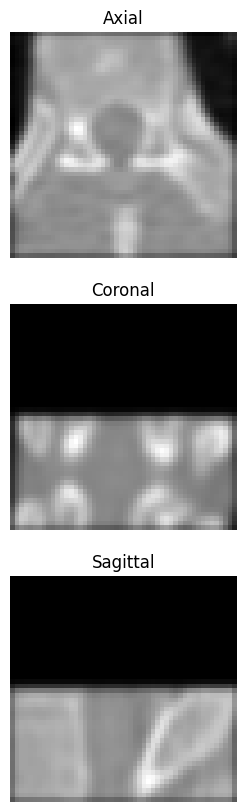

In [8]:
plot_3d_image(item[1][0])